# Code for Normalizing Flows based on the Tabak-Turner paper

In [365]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, gamma
from matplotlib.colors import LogNorm
import cvxpy as cp

def estimate_forward_KL(X, flow, log_rho_exact):

    # compute log-density under the exact model
    log_ex = log_rho_exact(X)

    # compute log-density under the flow estimate
    log_est = flow.log_prob(X)

    # Monte Carlo KL
    kl_mc = np.mean(log_ex - log_est)
    return kl_mc


class NormalizingFlow:
    """
    An implementation of the non-parametric density estimator using normalizing flows,
    as described in "A family of non-parametric density estimation algorithms"
    by E. G. Tabak and C. V. Turner.

    This implementation uses the method of composing simple, localized
    radial expansion maps. The parameters of each map are found by maximizing a
    local quadratic approximation to the log-likelihood.
    """

    def __init__(self, n_p=50, epsilon=0.5):
        """
        Initializes the density estimator.

        Args:
            n_p (int): The typical number of points each local map should influence.
                       This controls the resolution or "bandwidth" of the estimate.
                       Corresponds to n_p in equation (13) of the paper.
            epsilon (float): The maximum step size for the parameter of each map.
                             This caps the learning rate to ensure stability.
        """
        self.n_p = n_p
        self.epsilon = epsilon
        self.maps = []
        self.preconditioning = {}
        self.kl_history = []

    def _volume_n_ball(self, n):
        """Calculates the volume of an n-dimensional unit ball."""
        return np.pi**(n/2) / gamma(n/2 + 1)

    def _calculate_alpha(self, x0, n, m):
        """
        Calculates the length-scale 'alpha' for a map centered at x0, 
        based on equation (13) from the paper. The goal is to have the
        map's influence cover roughly n_p points.

        Args:
            x0 (np.ndarray): The center of the elementary map.
            n (int): The dimensionality of the data space.
            m (int): The total number of data points.

        Returns:
            float: The calculated alpha.
        """
        omega_n = self._volume_n_ball(n)
        # The formula in the paper is derived for a target normal distribution.
        # It adapts the map's radius to be larger in low-density regions.
        term = (omega_n**-1 * self.n_p / m)**(1/n)
        alpha = (2 * np.pi)**0.5 * term * np.exp(np.linalg.norm(x0)**2 / (2*n))
        return alpha

    def _radial_f(self, r, alpha):
        """
        The radial localization function f(r), based on equation (24).
        Handles the r=0 case to avoid division by zero.

        Args:
            r (np.ndarray): Array of radial distances ||x - x0||.
            alpha (float): The length-scale of the map.

        Returns:
            np.ndarray: The value of the localization function.
        """
        # Handle r=0 separately to avoid division by zero.
        # The limit of erf(x)/x as x->0 is 2/sqrt(pi).
        f_vals = np.zeros_like(r)
        nonzero_r = r != 0
        zero_r = ~nonzero_r

        r_scaled = r[nonzero_r] / alpha
        f_vals[nonzero_r] = erf(r_scaled) / r[nonzero_r]
        f_vals[zero_r] = 2.0 / (alpha * np.sqrt(np.pi))
        return f_vals

    def _radial_f_prime(self, r, alpha):
        """
        The derivative of the radial localization function, f'(r).
        Handles the r=0 case, where the derivative is 0.

        Args:
            r (np.ndarray): Array of radial distances ||x - x0||.
            alpha (float): The length-scale of the map.

        Returns:
            np.ndarray: The value of the derivative.
        """
        f_prime_vals = np.zeros_like(r)
        nonzero_r = r != 0
        
        r_nz = r[nonzero_r]
        r_scaled = r_nz / alpha
        
        term1 = (2.0 / (alpha * np.sqrt(np.pi))) * np.exp(-r_scaled**2)
        term2 = erf(r_scaled) / r_nz
        f_prime_vals[nonzero_r] = (term1 - term2) / r_nz
        
        return f_prime_vals


    # Input: points are array of points, values are array of values where each point evaluates, j is index of points
    # Output: true if point j has the tangent plane lays below all the points. 
    def check_dual(self, points, values, j):
        N = len(points)
        alpha = cp.Variable(N)
        
        constraints = [
            alpha >= 0,
            cp.sum(cp.multiply(alpha[:, None], points - points[j]), axis=0) == 0
        ]
        
        objective = cp.Minimize(cp.sum(cp.multiply(alpha, values - values[j])))
    
        prob = cp.Problem(objective, constraints)
        prob.solve()
    
        # If the optimal value is -\infty, dual is feasible, then the primal is infeasible
        return prob.status != cp.UNBOUNDED  # return True means primal is feasible
    
    # check dual LP each point j. Use this version of check if we have large number of points.
    # Input: points are array of points, values are array of values where each point evaluates.
    # Output: true if points can interpolate the convex function.
    def dual_interpolation_check(self, points, values):
        return all(self.check_dual(points, values, j) for j in range(len(points)))
    

    def fit(self, x, log_rho_exact=None, n_steps=1000):
        """
        Fits the density model to the data by building a sequence of maps.
        """
        m, n = x.shape
        tol = 1e-9 # Tolerance for Hessian
        
        # Starting map
        mean = np.mean(x, axis=0)
        z = x - mean
        std = np.sqrt(np.mean(np.sum(z**2, axis=1)) / n)
        z /= std
    
        self.preconditioning = {'mean': mean, 'std': std}
        z0 = z.copy()
        self.maps = []
    
        # Iterative map building
        for i in range(n_steps):
            # 1. Select a center x0
            if np.random.rand() > 0.5:
                # Pick from the actual observations at their current normalized state
                idx = np.random.randint(m)
                x0 = z[idx]
            else:
                # Sample the target normal distribution to keep x0 from becoming too large
                x0 = np.random.randn(n)
    
            # 2. Calculate length-scale alpha
            alpha = self._calculate_alpha(x0, n, m)
    
            # 3. Calculate Gradient (G) and Hessian (H) of log-likelihood
            r = np.linalg.norm(z0 - x0, axis=1)
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)
    
            term_G = n + np.dot(z, x0) - np.sum(z**2, axis=1)
            G = np.sum(term_G * f + r * f_prime)
    
            term_H1 = (n + r**2) * f**2
            term_H2 = 2 * r * f * f_prime
            term_H3 = (r * f_prime)**2
            H = -np.sum(term_H1 + term_H2 + term_H3)
    
            if np.abs(H) < tol:
                continue
    
            # 4. Calculate optimal step beta and constrain it
            beta = -G / H

            if beta >= 0: 
                # accept directly; convexity guaranteed for our F
                pass
            else:
                # Build base potential φ_base(z0) = 0.5||z0||^2 + sum_{prev k} β_k F_k(r_k)
                phi_base = 0.5 * np.sum(z0**2, axis=1)
                for q in self.maps:
                    rq = np.linalg.norm(z0 - q['x0'], axis=1)
                    Fq = rq * erf(rq / q['alpha']) + (q['alpha'] / np.sqrt(np.pi)) * np.exp(-(rq / q['alpha'])**2)
                    phi_base += q['beta'] * Fq
                
                # New step's F(r) for current (x0, alpha)
                F_new = r * erf(r / alpha) + (alpha / np.sqrt(np.pi)) * np.exp(-(r / alpha)**2)
                
                # Backtrack β by convexity LP on the potential values
                max_halving = 20
                for _ in range(max_halving):
                    phi_cand = phi_base + beta * F_new  # candidate potential values at the sample anchors z0
                    if self.dual_interpolation_check(z0, phi_cand):   # your dual LP checker
                        break
                    beta /= 1.25
                else:
                    # If all attempts fail, skip this step
                    continue
    
            # 5. Apply the map to transform the data
            z = z + beta * f[:, np.newaxis] * (z0 - x0)
            
            # 6. Store the map's parameters
            self.maps.append({'x0': x0, 'alpha': alpha, 'beta': beta})

            if log_rho_exact is not None:
                # Estimate the KL divergence if the exact log density is provided
                kl = estimate_forward_KL(x, self, log_rho_exact)
                self.kl_history.append(kl)
            
            if (i+1) % (n_steps//10) == 0:
                if log_rho_exact is None:
                    print(f"Step {i+1}/{n_steps} completed")
                else:
                    kl = estimate_forward_KL(x, self, log_rho_exact)
                    print(f"Step {i+1}/{n_steps} completed, KL estimate: {kl:.4f}")


    def _transform(self, x_new):
        """Applies the full sequence of learned maps to new data."""
        if x_new.ndim == 1:
            x_new = x_new.reshape(1, -1)
        m, n = x_new.shape
        
        # Apply preconditioning and store original z0
        z0 = (x_new - self.preconditioning['mean']) / self.preconditioning['std']
        z = z0.copy()
        
        # Calculate initial log Jacobian from preconditioning
        log_J = np.full(m, -n * np.log(self.preconditioning['std']))
    
       # --- before the loop, right after computing z0, z, and log_J ---
        J = np.tile(np.eye(n), (m, 1, 1))   # initialize per-sample Jacobian to identity
        
        # --- Apply sequence of maps (anchored update) ---
        for p in self.maps:
            x0, alpha, beta = p['x0'], p['alpha'], p['beta']
        
            r = np.linalg.norm(z0 - x0, axis=1)
            r_safe = np.maximum(r, 1e-12)  # prevent division by zero
        
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)
        
            diff = z0 - x0
            outer_product = diff[:, :, np.newaxis] * diff[:, np.newaxis, :]
        
            J += beta * f.reshape(-1,1,1) * np.identity(n) \
                 + beta * (f_prime / r_safe).reshape(-1,1,1) * outer_product
        
            # Apply the anchored residual map
            z = z + beta * f[:, np.newaxis] * (z0 - x0)
        
        # --- after the loop, add the anchored log-det once per sample ---
        log_J = log_J + np.log(np.abs(np.linalg.det(J)))
            
        return z, log_J

    def log_prob(self, x_new):
        """
        Calculates the log probability density log(rho(x)) for new data points.

        Args:
            x_new (np.ndarray): New data points, shape (m, n).

        Returns:
            np.ndarray: The log probability for each point.
        """
        m, n = x_new.shape
        
        # Transform data to the target distribution space (y) and get log Jacobian
        y, log_J = self._transform(x_new)

        # Calculate log probability in the target Gaussian space
        log_prob_gaussian = -0.5 * np.sum(y**2, axis=1) - 0.5 * n * np.log(2 * np.pi)

        # Final log probability is log(rho(x)) = log(mu(y(x))) + log(J(x))
        return log_prob_gaussian + log_J
    
    import numpy as np

    def _transport_map(self, z):
        """
        Evaluate T(z) for a single z (shape: (n,))
        """
        Tz = z.copy()
        for p in self.maps:
            x0, alpha, beta = p['x0'], p['alpha'], p['beta']
            diff = z - x0
            r = np.linalg.norm(diff)
            f = self._radial_f(np.array([r]), alpha)[0]
            Tz += beta * f * diff
        return Tz
    
    
    def _transport_jacobian(self, z):
        """
        Compute Jacobian ∇T(z) for a single z ∈ R^n
        """
        n = z.shape[0]
        J = np.eye(n)
        
        for p in self.maps:
            x0, alpha, beta = p['x0'], p['alpha'], p['beta']
            diff = z - x0
            r = np.linalg.norm(diff)
            if r == 0:
                continue  # avoid division by zero
    
            f = self._radial_f(np.array([r]), alpha)[0]
            f_prime = self._radial_f_prime(np.array([r]), alpha)[0]
    
            outer = np.outer(diff, diff)
            J += beta * (f * np.eye(n) + (f_prime / r) * outer)
    
        return J
    
    
    def _inverse_single_sample_newton(self, y, num_iter=20, tol=1e-10):
        """
        Invert T(z) = y using Newton’s method for one sample y ∈ R^n
        """
        z = y.copy()
    
        for _ in range(num_iter):
            Tz = self._transport_map(z)
            Fz = Tz - y
            J = self._transport_jacobian(z)
    
            try:
                delta = np.linalg.solve(J, Fz)
            except np.linalg.LinAlgError:
                raise RuntimeError("Jacobian is singular")
    
            z_new = z - delta
    
            if np.linalg.norm(z_new - z) < tol:
                break
            z = z_new
    
        return z
    
    
    def sample(self, n_samples):
        """
        Generate samples using Newton inversion of T.
        """
        y_samples = np.random.randn(n_samples, len(self.maps[0]['x0']))
        z_samples = []
    
        for i in range(n_samples):
            z = self._inverse_single_sample_newton(y_samples[i])
            z_samples.append(z)
    
        z_samples = np.array(z_samples)
        return z_samples * self.preconditioning['std'] + self.preconditioning['mean']
        

In [367]:
import numpy as np

def sample_exact(n_samples):
    theta = np.random.randn(n_samples)
    r     = 1.0 + 0.1 * np.random.randn(n_samples)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.stack([x, y], axis=1)

def log_rho_exact(xy):
    x = xy[:,0]
    y = xy[:,1]
    r     = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)


    log_p_theta = -0.5*theta**2 - 0.5*np.log(2*np.pi)

    log_p_r = (
        -0.5*((r - 1.0)/0.1)**2
        - 0.5*np.log(2*np.pi*0.1**2)
    )

    # log Jacobian term
    log_jac = -np.log(r)

    return log_p_theta + log_p_r + log_jac



In [375]:

x = sample_exact(1000)  # Sample from the true target density
flow = NormalizingFlow(n_p=500)
n_steps = 600  # Number of steps to fit the model
flow.fit(x=x, log_rho_exact=log_rho_exact, n_steps=n_steps)


Step 60/600 completed, KL estimate: 0.8570
Step 120/600 completed, KL estimate: 0.6777
Step 180/600 completed, KL estimate: 0.4836
Step 240/600 completed, KL estimate: 0.3120
Step 300/600 completed, KL estimate: 0.2152
Step 360/600 completed, KL estimate: 0.1493
Step 420/600 completed, KL estimate: 0.0972
Step 480/600 completed, KL estimate: 0.0638
Step 540/600 completed, KL estimate: 0.0539
Step 600/600 completed, KL estimate: 0.0438


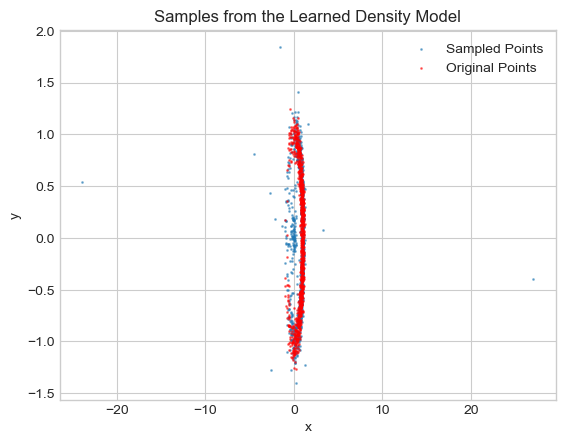

In [377]:
samples = flow.sample(1000)  # Generate samples from the learned density model

plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5, label='Sampled Points')
plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.5, color='red', label='Original Points')
plt.title('Samples from the Learned Density Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

([<matplotlib.axis.YTick at 0x23c87337f50>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

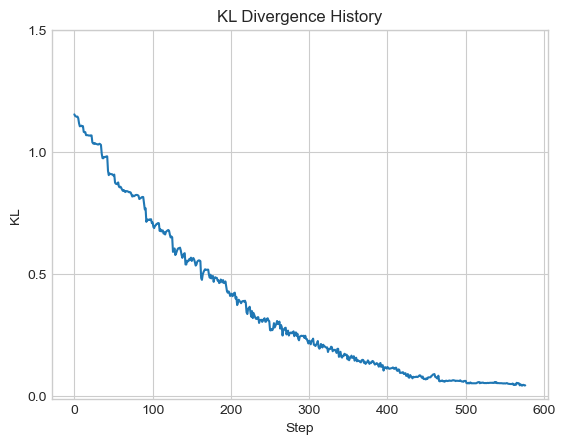

In [385]:
plt.plot(flow.kl_history)
plt.title('KL Divergence History')
plt.xlabel('Step')
plt.ylabel('KL')
plt.yticks([0, 0.5, 1.0, 1.5])

In [163]:
# Test Case 1
# This creates a crescent-shaped distribution, similar to the paper
m = 1000
angle = np.random.uniform(-np.pi/2, np.pi/2, m)
radius = 1.0 + 0.1 * np.random.randn(m)
x = np.zeros((m, 2))
x[:, 0] = radius * np.cos(angle)
x[:, 1] = radius * np.sin(angle)
x += 0.02 * np.random.randn(m, 2)

# Train the model
# Using parameters similar to the paper.
# n_p = 50
# n_steps = 500.
model = NormalizingFlow(n_p=50, epsilon=0.5)
model.fit(x, n_steps=200)

Step 20/200 completed
Step 40/200 completed
Step 60/200 completed
Step 100/200 completed
Step 120/200 completed
Step 160/200 completed
Step 180/200 completed


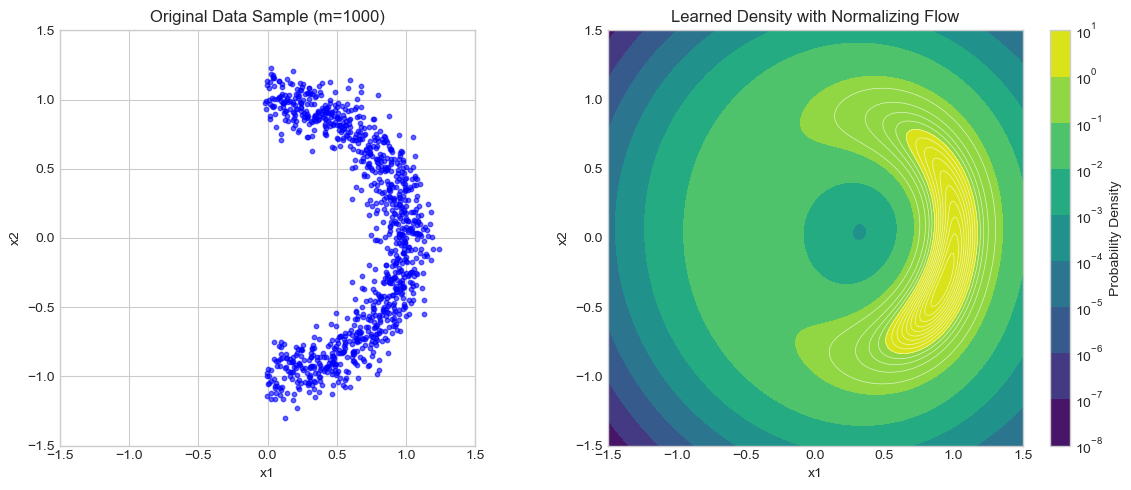

In [165]:
# Results
# Create a grid of points to evaluate the learned density
grid_res = 1000
x_range = np.linspace(-1.5, 1.5, grid_res)
y_range = np.linspace(-1.5, 1.5, grid_res)
xx, yy = np.meshgrid(x_range, y_range)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Calculate the probability on the grid
log_p = flow.log_prob(grid_points)
p = np.exp(log_p).reshape(grid_res, grid_res)

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(12, 5))

# Plot 1: Original Data
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x[:, 0], x[:, 1], s=10, alpha=0.6, c='blue')
ax1.set_title("Original Data Sample (m=1000)")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

# Plot 2: Learned Density
ax2 = fig.add_subplot(1, 2, 2)
# Use LogNorm for better visualization of low-density areas
contour = ax2.contourf(xx, yy, p, levels=15, cmap='viridis', norm=LogNorm())
ax2.contour(xx, yy, p, levels=15, colors='white', linewidths=0.5, alpha=0.7)
fig.colorbar(contour, ax=ax2, label="Probability Density")
ax2.set_title("Learned Density with Normalizing Flow")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()

In [ ]:
def f_erf(r, alpha):
    """
    (Used above)
    
    f(r) = erf(r/α) / r
    """
    # Create an output array of the same shape and type as r
    f_vals = np.zeros_like(r, dtype=float)
    
    # Identify non-zero elements to avoid division by zero
    nonzero_r = r != 0
    
    # Calculate for non-zero r
    r_nz = r[nonzero_r]
    r_scaled = r_nz / alpha
    f_vals[nonzero_r] = erf(r_scaled) / r_nz
    
    # For r=0, use the limit: lim_{x->0} erf(x)/x = 2/sqrt(pi)
    f_vals[~nonzero_r] = 2.0 / (alpha * np.sqrt(np.pi))
    
    return f_vals

def F_erf_related(r, alpha):
    """
    Implements the function F(r) from the image.

    F(r) = r * erf(r/α) + (α/√π) * exp(-(r/α)²)
    """
    r_scaled = r / alpha
    term1 = r * erf(r_scaled)
    term2 = (alpha / np.sqrt(np.pi)) * np.exp(-r_scaled**2)
    return term1 + term2

# --- Other Radial Functions ---

def f_algebraic(r, alpha):
    """
    f(r) = 1 / (α + r)
    """
    return 1.0 / (alpha + r)

def f_compact_support(r, alpha):
    """
    f(r) = (1/α) * (1 - r/α)² for r < α, and 0 otherwise.
    """
    # Use np.where to apply the condition efficiently on arrays
    vals = (1.0 / alpha) * (1.0 - r / alpha)**2
    return np.where(r < alpha, vals, 0.0)

def f_exponential(r, alpha):
    """
    Implements a convex exponential decay radial function.
    
    f(r) = exp(-r/α)
    """
    return np.exp(-r / alpha)